# Plot Radar Data

This notebook demonstrates plotting NEXRAD data using Python.

### Import Packages

In [1]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.calc import azimuth_range_to_lat_lon
from metpy.plots import colortables, USSTATES, USCOUNTIES
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr

import warnings
warnings.filterwarnings("ignore")

### Helper Function

In [2]:
def get_radar_file_url(datasets, date):
    '''A function to help find the desired satellite data based on the time given.
    
    Input:
     - List of datasets from a THREDDS Catalog
     - Date of desired dataset (datetime object)
     
    Output:
     - Index value of dataset closest to desired time
    '''
    rad_date_hour = date.strftime('%Y%m%d_%H')
    files = []
    times = []
    for file in cat.datasets:
        if rad_date_hour in file:
            times.append(datetime.strptime(file[-18:-5], '%Y%m%d_%H%M'))
            files.append(file)
    if not files:
        date = date - timedelta(hours=1)
        rad_date_hour = date.strftime('%Y%m%d_%H')
        for file in cat.datasets:
            if rad_date_hour in file:
                times.append(datetime.strptime(file[-18:-5], '%Y%m%d_%H%M'))
                files.append(file)
    find_file = np.abs(np.array(times) - date)
    return list(cat.datasets).index(files[np.argmin(find_file)])

## Get Data

In [14]:
date = datetime(2022, 4, 23, 2, 0)
#date = datetime.utcnow()

# Create variables for URL generation
station = 'KILN'

# Construct the data_url string
data_url = (f'https://thredds.ucar.edu/thredds/catalog/nexrad/level2/{station}/{date:%Y%m%d}/catalog.html')

# Get list of files available for particular day
cat = TDSCatalog(data_url)

# Use homemade function to get dataset for desired time
dataset = cat.datasets[get_radar_file_url(cat.datasets, date)]

ds = xr.open_dataset(dataset.access_urls['OPENDAP'], decode_times=False,
                     decode_coords=False, mask_and_scale=True)

## Parse Data, Create Lat/Lon

In [15]:
station = ds.Station
slat = ds.StationLatitude
slon = ds.StationLongitude
elevation = ds.StationElevationInMeters
vtime = datetime.strptime(ds.time_coverage_start, '%Y-%m-%dT%H:%M:%SZ')

sweep = 0
rng = ds.distanceR_HI.values
az = ds.azimuthR_HI.values[sweep]
ref = ds.Reflectivity_HI.values[sweep]

lon, lat = azimuth_range_to_lat_lon(az, rng, slon, slat)

## Make Plot

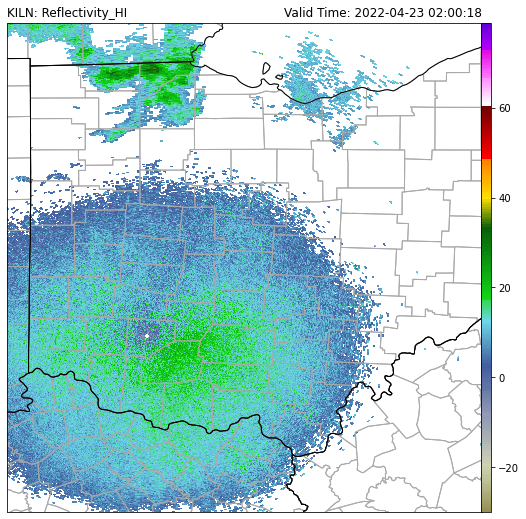

In [16]:
cmap = colortables.get_colortable('NWSStormClearReflectivity')

fig, ax = plt.subplots(1, 1, figsize=(10, 9), subplot_kw=dict(projection=ccrs.PlateCarree()))

img = ax.pcolormesh(lon, lat, ref, vmin=-30, vmax=79, cmap=cmap)
plt.colorbar(img, aspect=50, pad=0)

ax.set_extent([-85.0, -81.0, 38.625, 41.375], ccrs.PlateCarree()) #(-94.5, -78.5, 34.5, 45.5)
ax.set_aspect('equal', 'datalim')

ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='darkgrey')
ax.add_feature(USSTATES.with_scale('5m'))

plt.title(f'{station}: {ds.Reflectivity_HI.name}', loc='left')
plt.title(f'Valid Time: {vtime}', loc='right')
plt.show()